In [2]:
from torchdiffeq import odeint
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors
from mpl_toolkits import mplot3d
from numpy import linalg as la
from scipy import stats
from scipy import spatial as sp
from scipy import integrate as integ
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
from ipywidgets import interact, IntSlider


#import Networkx as net
import Plot3D as plot3d
import dataframe as dataframe

Using PA-NODE to learn the lorenz system. Moving to multiple spatial dimensions

# PA NODE

In [3]:
class Simple_FeedforwardNN(nn.Module):
    def __init__(self, input_dim, hidden_layers, depth, output_dim, activation_func=nn.Tanh()):
        super(Simple_FeedforwardNN, self).__init__()

        layers = []
        previous_depth = input_dim
        for _ in range(hidden_layers):
            layers.append(nn.Linear(previous_depth, depth))
            layers.append(activation_func)
            previous_depth = depth

        layers.append(nn.Linear(depth, output_dim))
        self.network = nn.Sequential(*layers)

        #Setting initial weights
        for m in self.network.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.2)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, x):
            out = self.network(x)
            return out

In [4]:
class Piecewise_Auto_NODE(Simple_FeedforwardNN):
    def __init__(self, spatial_dim, hidden_layers, depth, time_range, num_breakpoints, activation_func=nn.Tanh()):
        super().__init__(spatial_dim, hidden_layers, depth, spatial_dim*(num_breakpoints+1), activation_func)
        self.depth              = depth #Depth is number of neurons per hidden layer
        self.hiddenlayers       = hidden_layers #Number of internal hidden layers
        self.variables          = spatial_dim
        self.num_breakpoint     = num_breakpoints
        self.time_range         = time_range
        self.num_A              = (num_breakpoints+1)
        self.breakpoints        = torch.linspace(time_range[0], time_range[1], num_breakpoints+2) 
        self.break_params       = nn.Parameter(self.breakpoints[1:-1])
        self.k = 1  #steepness parameter for sigmoid function
    
    
    def sigmoid(self, x):
       out = torch.sigmoid(self.k*x)
       return out
    


    def forward(self, t, x):
     
        out = self.network(x).reshape(self.num_A, self.variables)

        #First interval 
        i1 = self.sigmoid(self.break_params[0] - t).unsqueeze(0)
        output = i1

        #Internal Intervals
        for i in range(0, self.break_params.shape[0]-1):
            a = self.sigmoid(t - self.break_params[i]).unsqueeze(0)
            b = self.sigmoid(self.break_params[i+1] - t).unsqueeze(0)
            c = a*b
            output = torch.concatenate([output, c])
            
        #Final interval 
        i_final = self.sigmoid(t - self.break_params[-1]).unsqueeze(0)
        output = torch.cat([output, i_final])
        indicator = output

        out2 = out*indicator
      
        #out[0] = out[0]*(t < self.break_params).float()
        #out[1] = out[1]*(t >= self.break_params).float()
        final_out = torch.sum(out2, dim=0)
        return final_out.unsqueeze(0)
    
  

# Model: Ground Truth

In [17]:
class Lorenz_nonauto:
    def __init__(self, rho, sigma = 10, beta = 8/3):
        #Setting system parameters
        self.sigma = sigma
        self.beta = beta
        self.rho = rho #should be a 1D function of time

    #Differential Equation
    def f(self, t, x):
        xdot = [self.sigma*(x[1]-x[0]),
                x[0]*(self.rho(t) - x[2]) - x[1],
                x[0]*x[1] - self.beta*x[2] ]

        return np.array(xdot)

In [18]:
parameter_f = lambda t: 25.0
Lorenz = Lorenz_nonauto(rho = parameter_f, sigma=10, beta=8/3)

In [19]:
t_Start = 0; t_Final =50; dt = 0.05; t_Eval = np.arange(t_Start, t_Final, dt); y0 = [1, 1, 1]

In [20]:
output = integ.solve_ivp(Lorenz.f, t_span=(t_Start, t_Final), y0=y0,
                            method = 'RK45', t_eval = t_Eval)

## Plotting

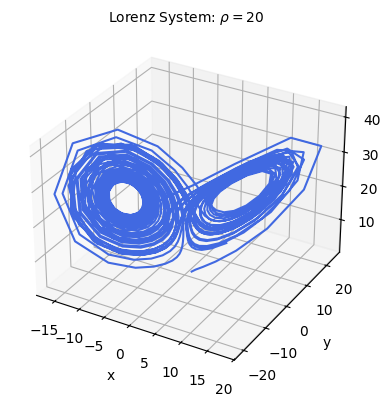

In [11]:
p2 = plot3d.plot3D(cols=2, rows=2, figsize=(10, 15))

p2.plot3D(output.y, plotNum=1, title = "Lorenz System: " + r'$\rho = 20$', tick_label_color='k') #+r'$ \sigma = $'+str(sigma)+" "+r'$ \rho = $'+str(rho) )


## Bifurcation Diagram

In [21]:
initial_conditions = [[1, 1, 1], [-1, -1, 1]]
r_eval = np.arange(0, 30, 0.01)

In [22]:
## Time 
t_Start = 0; t_Final = 250; t_Transient = 230; dt = 0.01

In [ ]:
#Should include linear interpolation for better results in bifurcation diagram.
x_list = []
r_list = []
for r in tqdm(r_eval):
    Lorenz.rho = lambda t: r
    
    for y0 in initial_conditions:
        output = integ.solve_ivp(fun = Lorenz.f, t_span = (t_Start, t_Final), y0 = y0, method = 'RK45', t_eval = np.arange(t_Start, t_Final, dt))
        z_plane = r-1
        z = output.y[2, int(t_Transient/dt):]

        #Where does do we cross the plane z = r-1 from below 
        
        indices = np.where((z[:-1] - z_plane)*(z[1:] - z_plane) <= 0)[0]
        for idx in indices:
            x_pts = output.y[0, int(t_Transient/dt):][idx]
            r_list.append(r)
            x_list.append(x_pts)

100%|██████████| 3000/3000 [16:16<00:00,  3.07it/s]


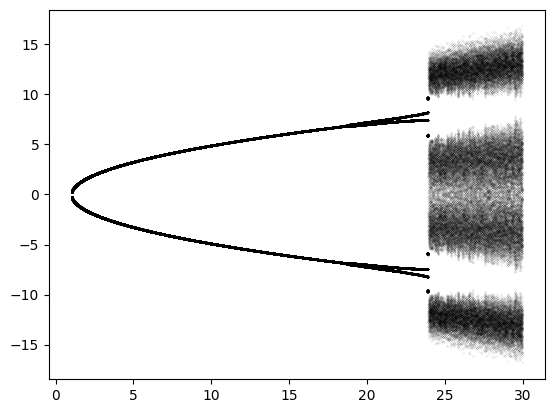

In [23]:
plt.plot(r_list, x_list, marker = '.', linestyle = 'None', markersize = 0.1, color = 'black')

## Non-Auto Lorenz

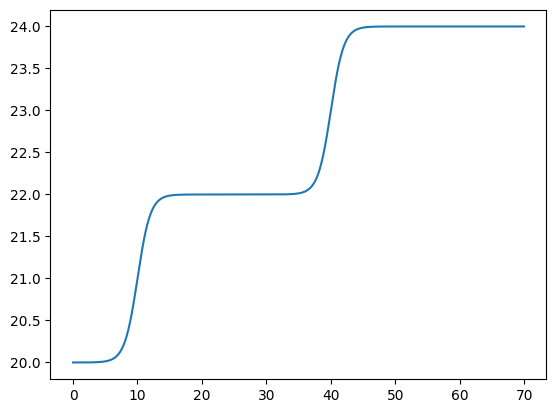

In [ ]:
## Sigmoid r 
k = 1
s_k = lambda t: torch.sigmoid(torch.tensor(k*t)).detach().numpy()

transition_pts = [10.0, 40.0]

parameter_f = lambda t: 20 + 2*s_k(t-transition_pts[0]) + 2*s_k(t-transition_pts[1]) 

t_Start = 0.0; t_Final = 150.0; dt = 0.05; t_Eval = np.arange(t_Start, t_Final, dt)
x= np.vectorize(parameter_f)(np.arange(0.0, 70.0, dt))
t = np.arange(0.0, 70.0, dt)
plt.plot(t, x)

In [63]:
Lorenz = Lorenz_nonauto(rho = parameter_f, sigma=10, beta=8/3)

In [5]:
output = integ.solve_ivp(Lorenz.f, t_span=(t_Start, t_Final), y0=[1, 1, 1],
                            method = 'RK45', t_eval = t_Eval)
output2 = integ.solve_ivp(Lorenz.f, t_span=(t_Start, t_Final), y0=[-1, -1 ,-1],
                            method = 'RK45', t_eval = t_Eval)

data2 = output2.y

NameError: name 'Lorenz' is not defined

In [65]:
output.y.shape

(3, 3000)

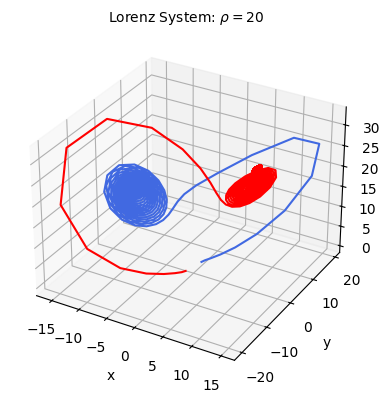

In [66]:
p2 = plot3d.plot3D(cols=2, rows=2, figsize=(10, 15))
p2.plot3D(output.y, plotNum=1, title = "Lorenz System: " + r'$\rho = 20$', tick_label_color='k')
plt.plot(data2[0, :], data2[1, :], data2[2, :], color='r')

In [67]:
def plot_interact(t):
    a = t
    p2 = plot3d.plot3D(cols=2, rows=2, figsize=(10, 15))
    p2.plot3D(output.y[:, :int(a/dt)], plotNum=1, title = "Lorenz System", tick_label_color='k')
    plt.plot(data2[0, :int(a/dt)], data2[1, :int(a/dt)], data2[2, :int(a/dt)], color='r')


In [ ]:
interact(plot_interact, t=IntSlider(min=0, max=150, step=1, value=0))

interactive(children=(IntSlider(value=0, description='t', max=150), Output()), _dom_classes=('widget-interact'…

<function __main__.plot_interact(t)>

# Training: Neural ODE

In [2]:
model = Piecewise_Auto_NODE(spatial_dim=3, hidden_layers=3, depth = 15, time_range = [0, 100], num_breakpoints=2)
loss_list = []

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.L1Loss()
model.k = 1 #Steepness of sigmoid 

NameError: name 'Piecewise_Auto_NODE' is not defined

In [6]:
x = torch.tensor([1.0, 1.0, 1.0]); t = torch.tensor([2.0])
model(t=t, x=x)

NameError: name 'model' is not defined

In [78]:
t_eval_tensor = torch.tensor(t_Eval[:2000])
data1_tensor = torch.tensor(output.y[:, :2000])

In [79]:
optimizer.zero_grad()
pred_x = odeint(model, x, t_eval_tensor.float(), method='rk4', options={'step_size': dt})
train_loss = loss_fn(pred_x, data1_tensor.T.float())

train_loss.backward()
optimizer.step()

print('Total Loss: ', train_loss)
print('')
print('Breakpoint: ', model.break_params)
print('')
print('Gradient of Breakpoint: ', model.break_params.grad)

Total Loss:  tensor(169.3447, grad_fn=<MseLossBackward0>)

Breakpoint:  Parameter containing:
tensor([33.3233, 66.6567], requires_grad=True)

Gradient of Breakpoint:  tensor([0.0627, 1.0322])


In [80]:
#Batching function
def batch(data, t, batch_length, batch_size):
    data_length = data.shape[0]
    indices = np.random.randint(0, data_length - batch_length, batch_size)
    batch_list = []
    batch_time_list = []

    for i in range(0, batch_size):
        batch_list.append(data[indices[i]:indices[i]+batch_length, :].float())
        batch_time_list.append(t[indices[i]:indices[i]+batch_length].float().requires_grad_(True))

    return batch_list, batch_time_list

In [81]:
data1_tensor.shape

torch.Size([3, 2000])

In [82]:
batch_length = 100
batch_size = 5
num_epochs = 1000
for epoch in tqdm(range(num_epochs)):
    
    batch_list, batch_time_list = batch(data1_tensor.T, t_eval_tensor, batch_length=batch_length, batch_size=batch_size)
    for i in range(0, batch_size):
        batch_i = batch_list[i]
        batch_time_i = batch_time_list[i]

        optimizer.zero_grad()

        #Predicting the trajectory
        pred_x = odeint(model, batch_i[0], batch_time_i, method='rk4', options={'step_size': dt})

        #Calculating loss
        loss = loss_fn(pred_x, batch_i)
        #loss_list.append(loss.item())

        #Backpropagation
        loss.backward()
        optimizer.step()
     
    
    if epoch%20==0:
            #Calculate training loss
            with torch.no_grad():
                  pred_x = odeint(model, data1_tensor[:, 0].float(), t_eval_tensor, method='rk4', options={'step_size': dt})
                  train_loss = loss_fn(pred_x, data1_tensor.T)
                  loss_list.append(train_loss.item())
               
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {train_loss.item()}')

  0%|          | 1/1000 [00:03<57:17,  3.44s/it]

Epoch 0, Loss: 254.35254500376797


 10%|█         | 101/1000 [06:35<1:17:38,  5.18s/it]

Epoch 100, Loss: 281.09207048650376


 20%|██        | 201/1000 [13:22<1:08:58,  5.18s/it]

Epoch 200, Loss: 245.14639962026098


 30%|███       | 301/1000 [2:48:38<59:26,  5.10s/it]      

Epoch 300, Loss: 270.3409278530813


 40%|████      | 401/1000 [2:55:31<53:25,  5.35s/it]

Epoch 400, Loss: 208.8714170556606


 50%|█████     | 501/1000 [3:02:28<44:03,  5.30s/it]

Epoch 500, Loss: 298.0316247490795


 60%|██████    | 601/1000 [3:09:25<35:21,  5.32s/it]

Epoch 600, Loss: 215.2576059694426


 70%|███████   | 701/1000 [3:15:43<22:15,  4.47s/it]

Epoch 700, Loss: 205.2881700403926


 80%|████████  | 801/1000 [3:21:34<14:39,  4.42s/it]

Epoch 800, Loss: 195.41765330339257


 90%|█████████ | 901/1000 [3:27:20<07:09,  4.34s/it]

Epoch 900, Loss: 159.24568853566905


100%|██████████| 1000/1000 [3:32:58<00:00, 12.78s/it]
